# <font color='blue'>A/B Tests</font>
## <font color='blue'>Pages with User Reviews Increase Online Product Sales?</font>

In [1]:
# Python Language Version
from platform import python_version
print('Python Language Version Used in This Jupyter Notebook:', python_version())

Python Language Version Used in This Jupyter Notebook: 3.7.16


## What Are A/B Tests?

For this project we are going to understand the results of an A/B Test run by an e-commerce website. Our goal is to help the company understand whether user evaluations (reviews) make a difference or not for the user to make a purchase on the portal.

The data are fictitious, but represent valid values for this type of work.

## How to Analyze A/B Tests?

In general, we perform these 5 steps to analyze an A/B Test:

1. We set up the experiment.

2. We performed the hypothesis test and recorded the success rate for each group.

3. We create the Plot of the distribution of the difference between the two samples.

4. We calculate the statistical power.

5. We assess how sample sizes affect A/B Testing.

## Loading the Data Set

In [2]:
# Imports
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

# Graphics formatting
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

## Loading and Understanding Data

Variant A: Shows the current number of user comments and ratings.

Variant B: Does not show user comments on the site.

In [3]:
# Load the dataset
# We will use dummy data, which represent values that would be possible in a real test
df_sales = pd.read_csv("data/dataset.csv")

In [4]:
# Visualiza 
df_sales.head()

,id,variant,purchase,date
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28


In [5]:
# Visualize
df_sales.tail()

,id,variant,purchase,date
54995,0x451451,A,False,2019-06-19
54996,0x871d51,A,False,2019-03-22
54997,0x50d163,A,False,2019-02-10
54998,0x3544c4,B,False,2020-01-09
54999,0x983331,A,False,2019-09-05


## Exploratory Analysis and Probability Calculation

In [6]:
# Shape
df_sales.shape

(55000, 4)

In [7]:
# Data type
df_sales.dtypes

id          object
variant     object
purchase      bool
date        object
dtype: object

In [8]:
# Max date
df_sales['date'].max()

'2020-01-30'

In [9]:
# Min date
df_sales['date'].min()

'2019-01-01'

In [10]:
# Checking null values
df_sales.isnull().sum()

id          0
variant     0
purchase    0
date        0
dtype: int64

In [11]:
# Checking duplicate ID
df_sales.id.value_counts().count()

55000

In [12]:
# Ratio of the conversion result
df_sales.purchase.value_counts()

False    46416
True      8584
Name: purchase, dtype: int64

In [13]:
# Ratio of variants shown to users
df_sales.variant.value_counts()

A    50000
B     5000
Name: variant, dtype: int64

Calculating basic probabilities.

**Variant A is the control group. Variant B is the test or treatment group.**

In [14]:
# Probability that a user will view variant A
df_sales[df_sales.variant == 'A'].shape[0] / df_sales.shape[0] * 100

90.9090909090909

In [15]:
# Probability that a user will view any variant
df_sales.shape[0] / df_sales.shape[0] * 100

100.0

In [16]:
# Probability that a user will view variant B
df_sales[df_sales.variant == 'B'].shape[0] / df_sales.shape[0] * 100

9.090909090909092

In [17]:
# Total purchases made (conversions)
df_sales.purchase.sum()

8584

In [18]:
# Total purchases made when the variant was A
df_sales[df_sales.variant == 'A'].purchase.sum()

7603

In [19]:
# Total purchases made when the variant was B
df_sales[df_sales.variant == 'B'].purchase.sum()

981

In [20]:
# Probability of conversion regardless of the received variant
df_sales.purchase.mean()

0.15607272727272728

In [21]:
# Given that an individual was in the control group, what is the probability of conversion?
df_sales[df_sales.variant == 'A'].purchase.mean()

0.15206

In [22]:
# Given that an individual was in the treatment group, what is the probability of conversion?
df_sales[df_sales.variant == 'B'].purchase.mean()

0.1962

As we can see, the probability of receiving the new page is approximately 10% and the total probability of conversion is 19%. We need to check that we have enough evidence to say that the treatment group leads to an increase in conversions.

## Task 1 - Setting Up the Experiment

Pages with User Reviews Increase Online Product Sales?

Variant A: Shows the current number of user comments and ratings

Variant B: Does not show user comments on the site

Note that because of the timestamp associated with each event, you can technically run a hypothesis test continuously as each event is observed.

However, the difficult question is when to stop once one variant is found to be significantly better than another or does this need to happen consistently over a certain amount of time? How long before you decide that neither variant is better than the other? Talk to the business area to define the best approach for the test and we will present some tips during this work.

These questions are the hardest parts associated with A/B Testing and analytics in general.

For now, consider that we need to make a decision based solely on the given data. If we want to assume that variant A is better, unless the new variant proves to be definitely better at a 5% Type I error rate, what should your null and alternative hypotheses be?

You can define your assumptions in terms of words or in notation like $p_{A}$ and $p_{B}$, which are the conversion probabilities for the new and old variants.

- H0: PB - PA = 0
- H1: PB - PA > 0

H0 tells us that the probability difference of the two groups is equal to zero.

H1 tells us that the probability difference of the two groups is greater than zero.

### Data Pre-Processing

We will do some heavy calculations and to simplify the process, we will filter the data and use only one of the months. Feel free to use data from longer periods.

In [23]:
# Function to extract year and month from date
def extract_date(x):
    return x[:7]

In [24]:
# Extract year and month from date column
df_sales['year_month'] = df_sales['date'].apply(extract_date)

In [25]:
# Visualize
df_sales.head()

,id,variant,purchase,date,year_month
0,0x6f9421,A,False,2019-12-26,2019-12
1,0x59d442,A,False,2019-08-16,2019-08
2,0x6db8f8,A,True,2019-03-18,2019-03
3,0x68245d,A,False,2019-02-13,2019-02
4,0x28566e,A,False,2019-09-28,2019-09


In [26]:
# We will only work with January/2020 data to simplify the process didactically
df_sales_2020 = df_sales[df_sales['year_month'] == '2020-01']

In [27]:
# Visualize
df_sales_2020.head()

,id,variant,purchase,date,year_month
5,0x792f1d,A,False,2020-01-14,2020-01
7,0x724b78,B,False,2020-01-23,2020-01
9,0x684bf9,A,False,2020-01-17,2020-01
10,0x6394dc,A,False,2020-01-06,2020-01
11,0x625f5d,A,False,2020-01-05,2020-01


In [28]:
# Shape
df_sales_2020.shape

(8821, 5)

### Baseline creation

Let's baseline the conversion rate before running the hypothesis test. This way, we'll know the base conversion rate and the desired increase in purchases that we'd like to test.

* A will be the control group
* B will be the test group

In [29]:
# Generate a dataframe
df_ab_data = df_sales_2020[['variant', 'purchase']]
df_ab_data.head()

,variant,purchase
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [30]:
# Shape
df_ab_data.shape

(8821, 2)

In [31]:
# Change column names
df_ab_data.columns = ['group', 'conversion']

In [32]:
# Visualize
df_ab_data.head()

,group,conversion
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [33]:
# Pivot table for summary data
df_ab_summary = df_ab_data.pivot_table(values = 'conversion', index = 'group', aggfunc = np.sum)

In [34]:
# Visualize the data
df_ab_summary.head()

,conversion
group,
A,587.0
B,981.0


In [35]:
# Summary with total
df_ab_summary['total'] = df_ab_data.pivot_table(values = 'conversion', index = 'group', aggfunc = lambda x: len(x))

In [36]:
# Summary with rate
df_ab_summary['rate'] = df_ab_data.pivot_table(values = 'conversion', index = 'group')

In [37]:
# Visualize the data
df_ab_summary.head()

,conversion,total,rate
group,,,
A,587.0,3821,0.153625
B,981.0,5000,0.196200


In [38]:
# Get the values of variant A
conversion_A = df_ab_summary['conversion'][0]
total_A = df_ab_summary['total'][0]
rate_A = df_ab_summary['rate'][0]

In [39]:
# Print the values of A
print(conversion_A)
print(total_A)
print(rate_A)

587.0
3821
0.15362470557445695


In [40]:
# Get the values of variant B
conversion_B = df_ab_summary['conversion'][1]
total_B = df_ab_summary['total'][1]
rate_B = df_ab_summary['rate'][1]

In [41]:
# Print the values of B
print(conversion_B)
print(total_B)
print(rate_B)

981.0
5000
0.1962


Baseline conversion rate.

Equal to $p$ in the context of a binomial distribution and $p$ is the probability of success.

In [42]:
# Baseline conversion rate.
base_conversion = rate_A
base_conversion

0.15362470557445695

Minimum Detectable Effect.

Sometimes referred to as the practical significance level.

In [43]:
# Minimal detectable effect
min_effect = rate_B - rate_A
min_effect

0.04257529442554306

## Task 2 - Executing the Hypothesis Test

We performed the hypothesis test and recorded the success rate for each group.

Statistical power or sensitivity.

Equals 1 - $\beta$.

Typically 80% is used for most analyses. It is the probability of rejecting the null hypothesis when the null hypothesis is in fact false.

Parameters we will use to run the test:

1- Alpha (Significance level) $\alpha$: normally 5%; probability of rejecting the null hypothesis when the null hypothesis is true

2- Beta $\beta$: probability of accepting the null hypothesis when the null hypothesis is really false.

In [44]:
# Parameters we will use to run the test
alfa = 0.05
beta = 0.2

In [45]:
# Sample size
n = 50000

We can assume that the distribution of our control group is binomial because the data are a series of Bernoulli trials, where each trial has only two possible outcomes (similar to a coin toss).
 
For the test we will use SciPy's binom() function

In [46]:
# Binomial Test (using 5% default for significance level)
binom_test = scs.binom(n, p = base_conversion)

In [47]:
help(binom_test)

Help on rv_frozen in module scipy.stats._distn_infrastructure object:

class rv_frozen(builtins.object)
 |  rv_frozen(dist, *args, **kwds)
 |  
 |  # Frozen RV class
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dist, *args, **kwds)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cdf(self, x)
 |  
 |  entropy(self)
 |  
 |  expect(self, func=None, lb=None, ub=None, conditional=False, **kwds)
 |  
 |  interval(self, alpha)
 |  
 |  isf(self, q)
 |  
 |  logcdf(self, x)
 |  
 |  logpdf(self, x)
 |  
 |  logpmf(self, k)
 |  
 |  logsf(self, x)
 |  
 |  mean(self)
 |  
 |  median(self)
 |  
 |  moment(self, n)
 |  
 |  pdf(self, x)
 |  
 |  pmf(self, k)
 |  
 |  ppf(self, q)
 |  
 |  rvs(self, size=None, random_state=None)
 |  
 |  sf(self, x)
 |  
 |  stats(self, moments='mv')
 |  
 |  std(self)
 |  
 |  support(self)
 |  
 |  var(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here

In [48]:
# Binomial test with the minimum effect (in our example 0.04 for the significance level)
binom_test_mde = scs.binom(n, p = base_conversion + min_effect)

Now we visualize the probability mass function (pmf).

<BarContainer object of 50001 artists>

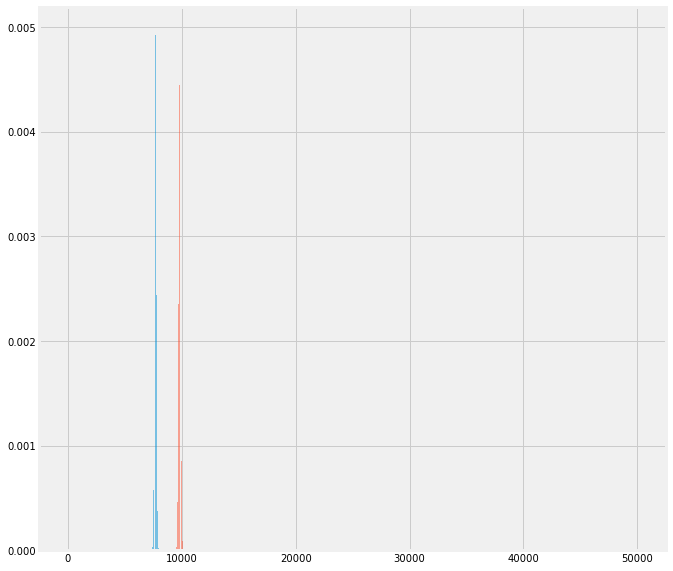

In [49]:
# Plot

# Plot area
fig, ax = plt.subplots(figsize = (10, 10))

# Define multiple values for x
x = np.linspace(0,int(n), int(n) + 1)

# We plot the results with a pmf and an alpha of 0.5
ax.bar(x, binom_test.pmf(x), alpha = 0.5)
ax.bar(x, binom_test_mde.pmf(x), alpha = 0.5)

## Task 3 - Distribution Plot

We plot the distribution of the difference between the two samples and compare the results.

We can compare the two groups by plotting the control group's distribution and calculating the probability of getting our test group's result.

Text(0, 0.5, 'Probability')

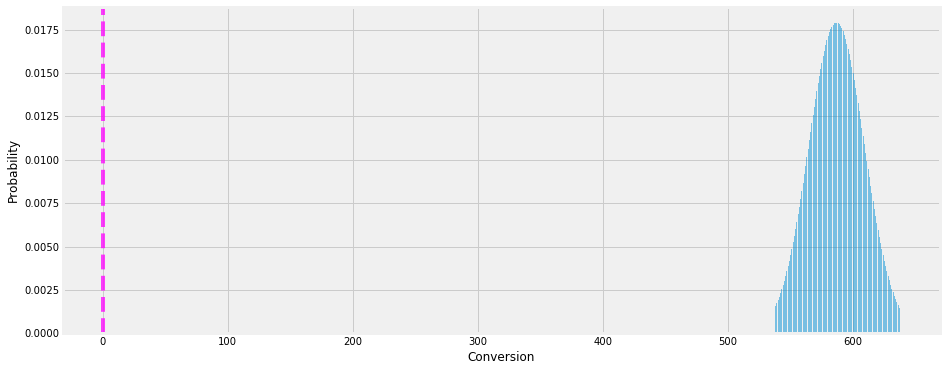

In [50]:
# Plot of the distribution of group A (control)

# Plot area
fig, ax = plt.subplots(figsize = (14,6))

# A test
x = np.linspace(conversion_A - 49, conversion_A + 50, 100)
y = scs.binom(total_A, rate_A).pmf(x)

# Create the vertical bar
ax.bar(x, y, alpha = 0.5)
ax.axvline(x = rate_B * rate_A, c = 'magenta', alpha = 0.75, linestyle = '--')

# Labels
plt.xlabel('Conversion')
plt.ylabel('Probability')

Text(0, 0.5, 'Probability')

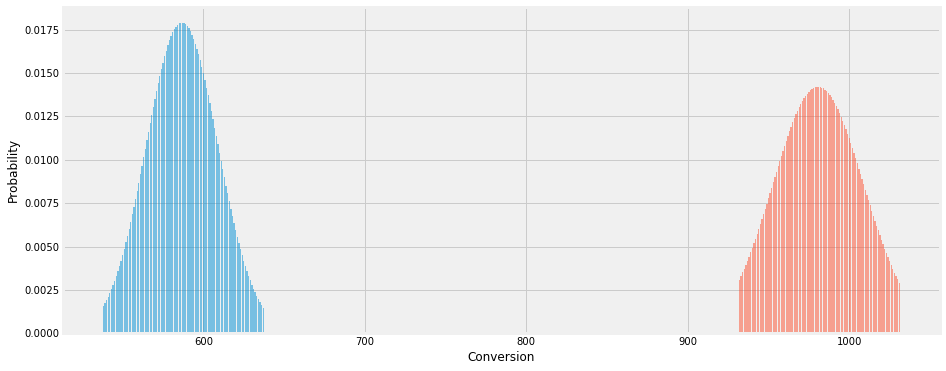

In [51]:
# Plot of the distribution of the 2 groups

# Plot area
fig, ax = plt.subplots(figsize = (14,6))

# A Chart
xA = np.linspace(conversion_A - 49, conversion_A + 50, 100)
yA = scs.binom(total_A, rate_A).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# B Chart
xB = np.linspace(conversion_B - 49, conversion_B + 50, 100)
yB = scs.binom(total_B, rate_B).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)

# Labels
plt.xlabel('Conversion')
plt.ylabel('Probability')

We can see that the test group converted more users than the control group. We can also see that the peak results of the test group are lower than those of the control group.

But how do we interpret the difference in peak probability?

We should focus instead on the conversion rate so that we have a like-for-like comparison. To calculate this, we need to standardize the data and compare the probability of success, p, for each group.

In [52]:
# Set variable names

# Odds (conversion rates)
p_A = rate_A
p_B = rate_B

# Number of conversions
N_A = 3821
N_B = 5000

In [53]:
# Standard error for the mean of both groups
SE_A = np.sqrt(p_A * (1 - p_A)) / np.sqrt(total_A)
SE_B = np.sqrt(p_B * (1 - p_B)) / np.sqrt(total_B)

In [54]:
# Print
print(SE_A)
print(SE_B)

0.005833423432971666
0.0056161474339621814


Text(0, 0.5, 'PDF - Probability Density Function')

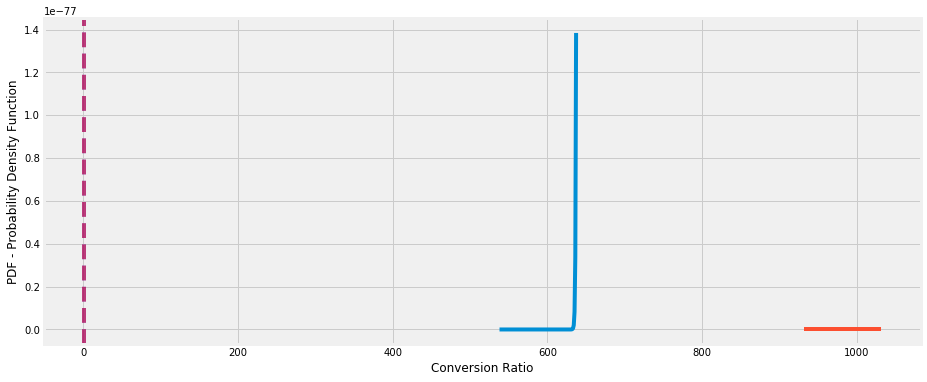

In [55]:
# Plot of the distributions of the null and alternative hypotheses

# Plot area
fig, ax = plt.subplots(figsize = (14,6))

# Data for the random variable
x = np.linspace(0, p_B - p_A, 100)

# Distribution of A
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(xA, yA)
ax.axvline(x = p_A, c = 'blue', alpha = 0.5, linestyle = '--')

# Distribution of B
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(xB, yB)
ax.axvline(x = p_B, c = 'red', alpha = 0.5, linestyle = '--')

# Labels
plt.xlabel('Conversion Ratio')
plt.ylabel('PDF - Probability Density Function')

The solid lines represent the average conversion rate for each group. The distance between the blue line and the red line is equal to the mean difference between the control and test group.

**Sum variance**

Remember that the null hypothesis states that the probability difference between the two groups is zero. Therefore, the mean for this normal distribution will be zero. The other property we will need for the normal distribution is the standard deviation or the variance.

Note: The variance is the standard deviation squared. The variance of the difference will depend on the probability variances for both groups.

### Checking the Null Hypothesis and the Alternative Hypothesis

**The null hypothesis is the position that the design change made to the test group would result in no change in conversion rate.**

**The alternative hypothesis is the opposing position that changing the design of the test group would result in an improvement (or decrease) in the conversion rate.**

The null hypothesis will be a normal distribution with a mean of zero and a standard deviation equal to the pooled standard error.

The alternative hypothesis has the same standard deviation as the null hypothesis, but the mean will be located at the difference in conversion rate, d_hat. This makes sense because we can calculate the difference in conversion rates directly from the data, but the normal distribution represents possible values our experiment could have given us.

In [56]:
# Calculating the pooled probability
group_prob = (p_A * N_A + p_B * N_B) / (N_A + N_B)

In [57]:
# Calculating z
z = (p_B - p_A) / (group_prob * (1 - group_prob) * (1 / N_A + 1 / N_B))**0.5
z

5.1827257006909795

In [58]:
# Check if z is greater than 1.64 (0.05 significance level)
z > 1.64

True

### Probability Distribution Plot

We will create a series of auxiliary functions for plotting probability distributions

In [59]:
# Function that returns the pooled probability for 2 samples
def group_prob_func(N_A, N_B, X_A, X_B):
    return (X_A + X_B) / (N_A + N_B)

In [60]:
# Function that returns grouped standard error for 2 samples
def standard_error_group_func(N_A, N_B, X_A, X_B):
    p_hat = group_prob_func(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE

In [61]:
# Returns the z value for a given significance level
def z_val(sig_level = 0.05, two_tailed = True):
    
    # Generate distribution for the z value
    z_dist = scs.norm()
    
    # Check if we should check both tails
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    # Z value
    z = z_dist.ppf(area)

    return z

In [62]:
# Calculate the confidence interval
def confidence_interval(sample_mean = 0, sample_std = 1, sample_size = 1, sig_level = 0.05):
    
    # Calculate the value of z
    z = z_val(sig_level)

    # Limits left and right
    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

In [63]:
# Function that calculates the confidence interval of two tails
def plot_CI(ax, 
            mu, 
            s, 
            sig_level = 0.05, 
            color = 'grey'):

    # Calculate the confidence interval
    left, right = confidence_interval(sample_mean = mu, sample_std = s, sig_level = sig_level)
    
    # Include the range in the graph
    ax.axvline(left, c = color, linestyle = '--', alpha = 0.5)
    ax.axvline(right, c = color, linestyle = '--', alpha = 0.5)

In [64]:
# Function to plot a normal distribution
def plot_norm_dist(ax, 
                   mu, 
                   std, 
                   with_CI = False, 
                   sig_level = 0.05, 
                   label = None):

    # Generate values for the random variable x
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    
    # Create the normal distribution
    y = scs.norm(mu, std).pdf(x)
    
    # Plot
    ax.plot(x, y, label = label)

    # If we have a confidence interval, we include it in the plot
    if with_CI:
        plot_CI(ax, mu, std, sig_level = sig_level)

Function to plot the null hypothesis distribution where, if there is no real change, the distribution of differences between test and control groups will be normally distributed.

In [65]:
# Function to plot the distribution of H0
def plot_H0(ax, stderr):
    plot_norm_dist(ax, 0, stderr, label = "H0 - Null Hypothesis")
    plot_CI(ax, mu = 0, s = stderr, sig_level = 0.05)

Function to plot the alternative hypothesis distribution where, if there is an actual change, the distribution of differences between the test and control groups will be normally distributed and centered around d_hat

In [66]:
# Function to plot the distribution of H1
def plot_H1(ax, stderr, d_hat):
    plot_norm_dist(ax, d_hat, stderr, label = "H1 - Alternative Hypothesis")

In [67]:
# Function that fills between upper significance limit and distribution for alternative hypothesis
def show_area(ax, d_hat, stderr, sig_level):

    # Confidence interval
    left, right = confidence_interval(sample_mean = 0, sample_std = stderr, sig_level = sig_level)
    
    # Values for x
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    
    # H0
    null = ab_dist(stderr, 'control')
    
    # H1
    alternative = ab_dist(stderr, d_hat, 'test')

    # If the type of the area equals power
    # We fill between the upper significance limit and the distribution for alternative hypothesis
    ax.fill_between(x, 0, alternative.pdf(x), color = 'green', alpha = 0.25, where = (x > right))
    ax.text(-3 * stderr, null.pdf(0), 'power = {0:.3f}'.format(1 - alternative.cdf(right)), 
                fontsize = 12, ha = 'right', color = 'k')

In [68]:
# Function that returns a distribution object depending on the group type
def ab_dist(stderr, d_hat = 0, group_type = 'control'):

    # Check the group type
    if group_type == 'control':
        sample_mean = 0
    elif group_type == 'test':
        sample_mean = d_hat

    # Create a normal distribution that depends on the mean and standard deviation
    dist = scs.norm(sample_mean, stderr)
    return dist

In [69]:
# Function that returns the value p
def p_val(N_A, N_B, p_A, p_B):
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [70]:
# Function to plot the A/B Test analysis
def abplot_func(N_A, 
                N_B, 
                bcr, 
                d_hat, 
                sig_level = 0.05, 
                show_p_value = False,
                show_legend = True):
   
    # Set the plot area
    fig, ax = plt.subplots(figsize = (14, 8))

    # Define parameters to find the grouped standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = standard_error_group_func(N_A, N_B, X_A, X_B)

    # Null and alternative hypothesis distribution plot
    plot_H0(ax, stderr)
    plot_H1(ax, stderr, d_hat)

    # Definir a extensão da área do plot
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # Adjust the graph and fill the inner area
    show_area(ax, d_hat, stderr, sig_level)

    # We show p-values based on the distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, bcr + d_hat)
        ax.text(3 * stderr, null.pdf(0), 'P-Value = {0:.4f}'.format(p_value), fontsize = 14, ha = 'left')

    # Show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

Now that we understand the derivation of the combined standard error, we can just directly plot the null and alternative hypotheses for future experiments.

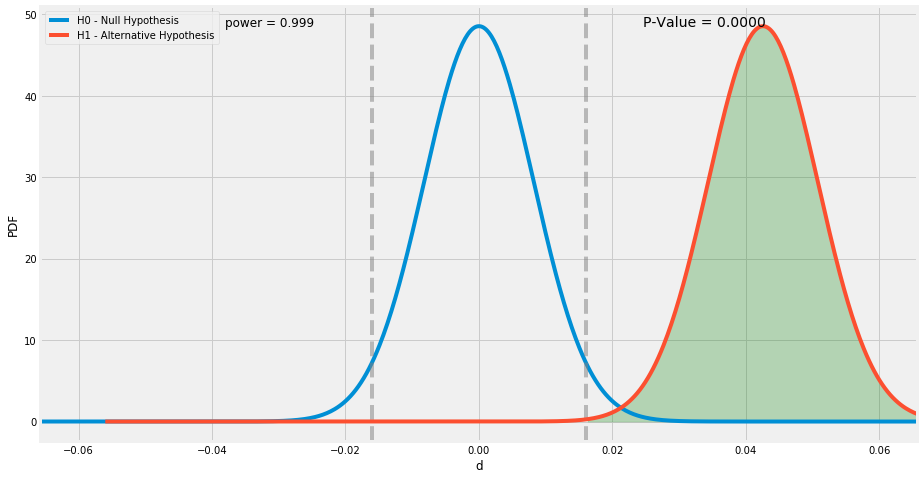

In [71]:
# We define the parameters and execute the function
n = N_A + N_B
base_conversion = p_A  
d_hat = p_B - p_A
abplot_func(N_A, N_B, base_conversion, d_hat, show_p_value = True)

Visually, the plot for the null and alternative hypotheses looks very similar to the other plots above. Fortunately, the two curves are identical in shape, so we can only compare the distance between the means of the two distributions. We can see that the alternative hypothesis curve suggests that the test group has a higher conversion rate than the control group. This graph can also be used to directly determine statistical power.

## Task 4 - Calculating Statistical Power

Statistical Power and Significance Level

It is easier to define the statistical power and significance level by first showing how they are plotted on the null and alternative hypothesis graph. We can return a visualization of the stat power by adding the parameter show_power = True

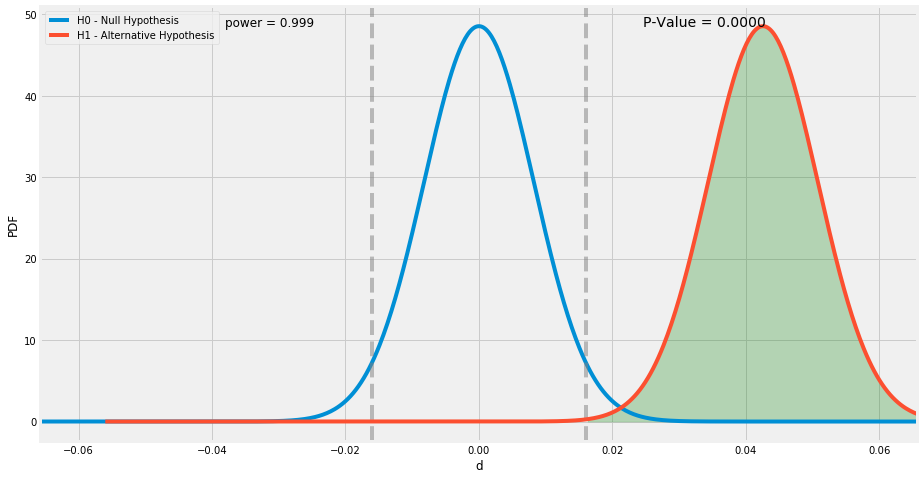

In [72]:
# Run the function
abplot_func(N_A, N_B, base_conversion, d_hat, show_p_value = True)

The green shaded area represents the statistical power and the calculated value for the power is also displayed on the graph. The gray dashed lines in the graph above represent the confidence interval (95% for the graph above) for the null hypothesis. Statistical power is calculated by finding the area under the alternative hypothesis distribution and outside the null hypothesis confidence interval.

After running our experiment, we get a resulting conversion rate for both groups. If we calculate the difference between the conversion rates, we end up with a result, the difference or the effect of changing the design of the webpage, not showing user ratings. Our task is to determine which population this result came from, the null hypothesis or the alternative hypothesis.

The area under the curve of the alternative hypothesis is equal to 1. If the alternative design (no evaluations) is actually better, the power is the probability that we accept the alternative hypothesis and reject the null hypothesis and is equal to the area shaded in green (true positive). The opposite area under the alternative curve is the probability of not rejecting the null hypothesis and rejecting the alternative hypothesis (false negative). This is known as beta in A/B testing or hypothesis testing and is shown below.

If the null hypothesis is true and there really is no difference between the control and test groups, the significance level is the probability that we reject the null hypothesis and accept the alternative hypothesis (false positive). A false positive is when we mistakenly conclude that the new design is better. This value is low because we want to limit this probability.

Often, a problem will be provided with a desired confidence level rather than a significance level. A typical 95% confidence level for an A/B test corresponds to a significance level of 0.05.

Experiments are typically set to a minimum desired power of 80%. If our new design is really better, we want our experiment to show that there is at least an 80% probability that this is the case. We know that if we increase the sample size for each group, we decrease the combined variance for our null and alternative hypotheses. This will make our distributions much narrower and can increase statistical power. Let's take a look at how sample size will directly affect our results.

## Task 5 - Influence of Sample Size on A/B Testing

Our curves for the null and alternative hypothesis have become narrower, and more of the area under the alternative curve is located to the right of the gray dashed line. The result for power is greater than 0.80 and meets our statistical power reference. Now we can say that our results are statistically significant.

The next problem we must encounter is determining the minimum sample size we will need for the experiment. And that's useful to know because it's directly related to how quickly we can complete experiments and deliver statistically meaningful results to the business.

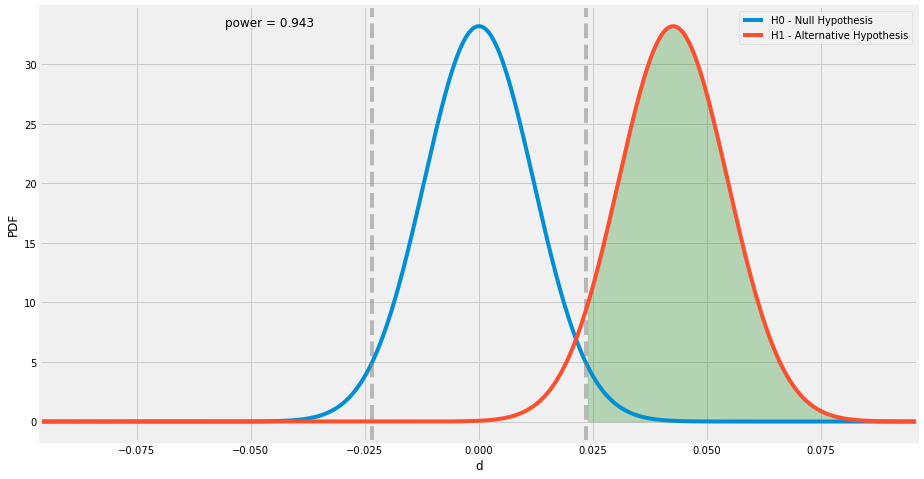

In [73]:
# Run the function
abplot_func(2000, 2000, base_conversion, d_hat)

We have the baseline conversion rate and the minimum detectable effect, which is the minimum difference between the control and test group that the business team will determine to be worth the investment of making the design change in the first place.

In [74]:
# Function to include the z value in the plot
def zplot(area = 0.95, two_tailed = True, align_right = False):

    # Create the plot area
    fig = plt.figure(figsize = (12, 6))
    ax = fig.subplots()
    
    # Create the normal distribution
    norm = scs.norm()
    
    # Create the data points for the plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # Code to populate areas for bidirectional tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color = 'grey', linestyle = '--')
        ax.vlines(left, 0, norm.pdf(left), color = 'grey', linestyle = '--')

        ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = (x > left) & (x < right))
        
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), 
                 fontsize = 12, 
                 rotation = 90, 
                 va = "bottom", 
                 ha = "right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right), 
                 fontsize = 12, 
                 rotation = 90, 
                 va = "bottom", 
                 ha = "left")
    
    # For one-tail tests
    else:
        # Align right
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color = 'grey', linestyle = '--')
            ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), 
                     fontsize = 12, 
                     rotation = 90, 
                     va = "bottom", 
                     ha = "right")
        
        # Align left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color = 'grey', linestyle = '--')
            ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right), 
                     fontsize = 12, 
                     rotation = 90, 
                     va = "bottom", 
                     ha = "left")

    # Include text in the plot
    plt.text(0, 0.1, "Shaded Area = {0:.3f}".format(area), fontsize = 12, ha = 'center')
    
    # Labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()

In [75]:
# Print the z value
print(z)
print(z_val(sig_level = 0.05, two_tailed = False))
print(z > z_val(sig_level = 0.05, two_tailed = False))

5.1827257006909795
1.6448536269514722
True


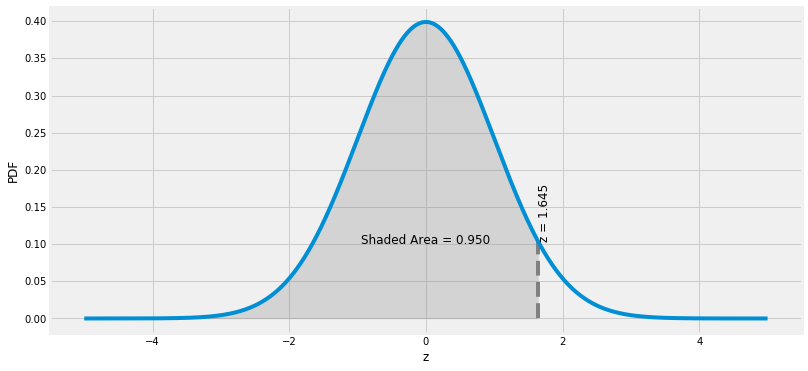

In [76]:
# Z plot
zplot(area = 0.95, two_tailed = False, align_right = False)

In [77]:
# Calculate z alpha and beta values
sig_level = 0.05
beta = 0.2
k = N_A/N_B
standard_norm = scs.norm(0, 1)
Z_beta = standard_norm.ppf(1-beta)
Z_alpha = standard_norm.ppf(1-sig_level)
print(Z_beta)
print(Z_alpha)

0.8416212335729143
1.6448536269514722


Let's calculate the minimum sample size needed.

In [78]:
# Function to find the minimum sample size
def calculate_min_samples_size(N_A, 
                               N_B, 
                               p_A, 
                               p_B, 
                               power = 0.8, 
                               sig_level = 0.05, 
                               two_sided = False):
   
    k = N_A/N_B
    
    # Normal distribution to determine the z values
    standard_norm = scs.norm(0, 1)

    # We find the z value for the statistical power
    Z_beta = standard_norm.ppf(power)
    
    # We find z alpha
    if two_sided == True:
        Z_alpha = standard_norm.ppf(1-sig_level/2)
    else:
        Z_alpha = standard_norm.ppf(1-sig_level)

    # clustered probability
    pooled_prob = (p_A + p_B) / 2

    # Minimum sample size
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / min_effect**2)    

    return min_N

In [79]:
# Calculate the minimum sample size with two_sided = True
calculate_min_samples_size(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = True)

1249.8068972849476

In [80]:
# Calculate the minimum sample size with two_sided = False
calculate_min_samples_size(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = False)

984.4720435225323

Now let's calculate the minimum sample size considering our baseline.

In [81]:
base_conversion + min_effect

0.1962

In [82]:
# Calculate the pooled probability
group_prob = (base_conversion + base_conversion + min_effect) / 2
group_prob

0.1749123527872285

In [83]:
# Sum of z alpha and beta
Z_beta + Z_alpha

2.4864748605243863

In [84]:
# Minimum sample size for the baseline
min_N = (2 * group_prob * (1 - group_prob) * (Z_beta + Z_alpha)**2 / min_effect**2)
min_N

984.4720435225323

Statistical power for the baseline.

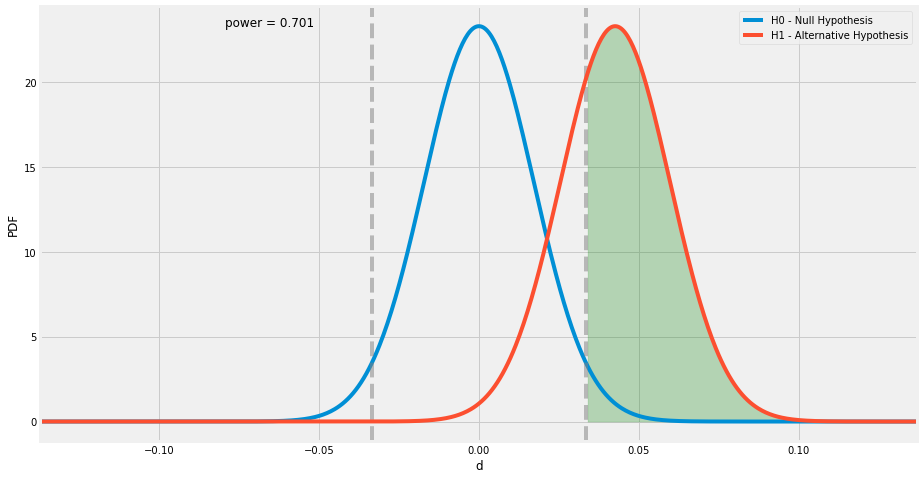

In [85]:
# Run the function for 984 samples
abplot_func(N_A = 984, 
            N_B = 984, 
            bcr = p_A, 
            d_hat = p_B - p_A, 
            sig_level = 0.05, 
            show_p_value = False, 
            show_legend = True)

Statistical power for the calculated sample size.

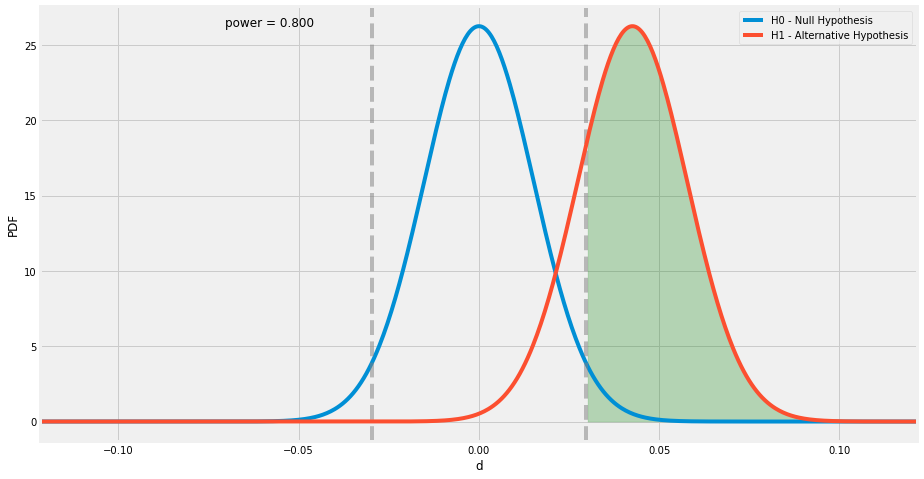

In [86]:
# Run the function for 1249 samples
abplot_func(N_A = 1249, 
            N_B = 1249, 
            bcr = p_A, 
            d_hat = p_B - p_A, 
            sig_level = 0.05, 
            show_p_value = False, 
            show_legend = True)

## Conclusion and Final Considerations

The calculated power for this sample size was approximately 0.80. So to claim that the page change removing user reviews actually increased the conversion rate we need at least 1249 samples.

# End